In [155]:
import numpy as np
import pandas as pd
import math
from random import randint
import matplotlib.pyplot as plt
import seaborn as sns

class Simulation:
    """
    PUT IN A DOCSTRING LIKE THE ONE BELOW
    A class to represent the simulation of a disease.

    ...

    Attributes
    ----------
    m : int
        the number of 'columns' of individuals
    n : int
        the number of 'rows' of individuals
    radius : int
        individuals can only be in contact with neighbours at a distance of at most r
    n_contacts : int
        average number of contacts (connections) per individual
    infected_locations : list of tuples of length two
        list of co-ordinates of individuals are infected
    prob_initially_exposed : float
        probability that an individual is exposed at the begin of the simulation
    prob_initially_infected : float
        probability that an individual is infected at the begin of the simulation
    prob_initially_recovered : float
        probability that an individual is immune to the infection at the begin of the simulation
    prob_recovery : float
        probability that an infected individual recovers on any given day
    prob_death : float
        probability that an infected individual dies on any given day
    prob_infects : float
        probability that an infected individual infects a contact on any given day
    prob_infectious : float
        probability that an exposed individual becomes infectious a on any given day
    duration : int
        duration (number of simulated days) for which the simulation is run


    Methods
    -------
    info(additional=""):
        Prints the person's name and age.
    """
    
    def __init__(self, m = 40, n = 25, radius = 6, n_contacts = 20, infected_locations = [], 
                 prob_initially_exposed = 0.01, prob_initially_infected = 0.01, prob_initially_recovered = 0,
                 prob_recovery = 0.025, prob_death = 0.0025, prob_infects = 0.1, prob_infectious = 0.1, duration = 200):
        self.m = m
        self.n = n
        self.r = radius
        self.k = n_contacts
        self.infected_locations = infected_locations
        self.prob_initially_exposed = prob_initially_exposed
        self.prob_initially_infected = prob_initially_infected
        self.prob_initially_recovered = prob_initially_recovered
        self.prob_recovery = prob_recovery
        self.prob_death = prob_death
        self.prob_infects = prob_infects
        self.prob_infectious = prob_infectious
        self.N = duration
        
        #define community where each individual has attributes: location, disease state and contacts
        #if the disease state is based on location, some checks are run on the values entered to ensure they're valid
        #assign disease state randomly or based on locations
        self.community = pd.DataFrame(index=list(range(self.n)), columns=[list(range(self.m))])
        for i in range(self.n):
            for j in range(self.m):
                self.community.iat[i,j] = {"l": (i, j), "s": ["S"], "c": []}
        if self.infected_locations == []:
            for i in range(self.n):
                for j in range(self.m):
                    self.community.iat[i,j]["s"][0] = np.random.choice(["S","E","I","R"], 1, True, 
                                                               [1-self.prob_initially_exposed-self.prob_initially_infected
                                                                -self.prob_initially_recovered,self.prob_initially_exposed,
                                                                self.prob_initially_infected, self.prob_initially_recovered])[0]
        else:
            if type(self.infected_locations) == list:
                for i in self.infected_locations:
                    if (type(i) == tuple and len(i)==2):
                        self.community.iat[i[0],i[1]]["s"][0] = "I"
                    else:
                        raise ValueError("Locations must be stored as tuples of length two e.g. (1,2).")
            else:
                raise ValueError("infected_locations must be a list of locations, e.g. [(1,2),(1,3)].") 
        
        #run check on average number of contacts to ensure it's possible given radius
        #draw random pair of individuals, check they aren't already connected/the same individual
        #if not, measure their Manhattan distance and if small enough then record a connection in both records
        #stop when (m*n*k)/2 connections are reached
        if self.k > 4+math.factorial(self.r)*4:
            raise ValueError("""The average number of contacts to be achieved (n_contacts) is larger than is possible for
                  the given radius.""")
        contacts = 0
        while contacts < (self.m*self.n*self.k)/2:
            p1 = self.community.iat[randint(0, n-1),randint(0, m-1)]
            p2 = self.community.iat[randint(0, n-1),randint(0, m-1)]
            m_dist = abs(p1["l"][0]-p2["l"][0]) + abs(p1["l"][1]-p2["l"][1])
            if (m_dist <= self.r) and not(p1["l"] in p2["c"]) and not(p2["l"] in p2["c"]) and not(p1 == p2):
                    self.community.iat[p1["l"]]["c"].append(p2["l"])
                    self.community.iat[p2["l"]]["c"].append(p1["l"])
                    contacts += 1
    
    def run(self):
        #a nested loop that runs once for each day and each person
        #add a blank string for tomorrow's potential new disease state to each person's information
        #check their current disease state
        for day in range(self.N):
            for i in range(self.n):
                for j in range(self.m):
                    self.community.iat[i,j]["s"].append("tomorrow's state")
                    
                    #for suceptible people, count their infected contacts, run an exposure simulation for each one
                    #if they are exposed by any contacts, record them exposed, otherwise record them suceptible
                    if self.community.iat[i,j]["s"][day] == "S":
                        infected_contacts = 0
                        for contact in self.community.iat[i,j]["c"]:
                            if self.community.iat[contact]["s"][day] == "I":
                                infected_contacts += 1
                        infection_sims = []
                        for sim in range(infected_contacts):
                            infection_sims.append(np.random.choice(["not exposed","exposed"], 1, True, 
                                                                    [1-self.prob_infects, self.prob_infects]))
                        if "exposed" in infection_sims:
                            self.community.iat[i,j]["s"][day+1] = "E"
                        else:
                            self.community.iat[i,j]["s"][day+1] = "S"
                    
                    #for exposed/infected people, run a simulation
                    #mark them exposed/infected/recovered/died accordingly
                    if self.community.iat[i,j]["s"][day] == "E":
                        exposure_outcome = np.random.choice(["not infectious","infectious"], 1, True, 
                                                            [1-self.prob_infectious, self.prob_infectious])
                        if exposure_outcome == "not infectious":
                            self.community.iat[i,j]["s"][day+1] = "E"
                        elif exposure_outcome == "infectious":
                            self.community.iat[i,j]["s"][day+1] = "I"
                    if self.community.iat[i,j]["s"][day] == "I":
                        infection_outcome = np.random.choice(["infectious","recovered", "dead"], 1, True, 
                                                             [1-self.prob_recovery-self.prob_death, 
                                                             self.prob_recovery, self.prob_death])
                        if infection_outcome == "infectious":
                            self.community.iat[i,j]["s"][day+1] = "I"
                        elif infection_outcome == "recovered":
                            self.community.iat[i,j]["s"][day+1] = "R"
                        elif infection_outcome == "dead":
                            self.community.iat[i,j]["s"][day+1] = "D"
                    
                    #for recovered/dead people, update the next days disease record with the same state
                    if self.community.iat[i,j]["s"][day] == "D":
                        self.community.iat[i,j]["s"][day+1] = "D"
                    if self.community.iat[i,j]["s"][day] == "R":
                        self.community.iat[i,j]["s"][day+1] = "R"
    
    def plot_state(self, time):
        #this method ommited to save time
        pass
    
    def chart(self):
        #create a dataframe of zeros with a row for each day and a column for each possible disease state
        #use nested loops to check the state of each person each day
        #add one to that day's row to whichever column matches their disease state
        #plot this using pyplot and format appropriately
        zero_data = np.zeros(shape=(self.N,5))
        chart_data = pd.DataFrame(zero_data, columns = ["Suceptible", "Exposed", "Infected", "Recovered", "Dead"])
        for day in range(self.N):
            for i in range(self.n):
                for j in range(self.m):
                    state = self.community.iat[i,j]["s"][day]
                    if state == "S":
                        chart_data.iat[day,0] = chart_data.iat[day,0] + 1
                    if state == "E":
                        chart_data.iat[day,1] = chart_data.iat[day,1] + 1
                    if state == "I":
                        chart_data.iat[day,2] = chart_data.iat[day,2] + 1
                    if state == "R":
                        chart_data.iat[day,3] = chart_data.iat[day,3] + 1
                    if state == "D":
                        chart_data.iat[day,4] = chart_data.iat[day,4] + 1
        plt.plot(range(self.N), chart_data["Suceptible"], "y-", label = "Suceptible")
        plt.plot(range(self.N), chart_data["Exposed"], "g-", label = "Exposed")
        plt.plot(range(self.N), chart_data["Infected"], "r-", label = "Infected")
        plt.plot(range(self.N), chart_data["Recovered"], "b-", label = "Recovered")
        plt.plot(range(self.N), chart_data["Dead"], "k-", label = "Dead")
        plt.legend()
        plt.xlabel("time")
        plt.ylabel("number")
        plt.show()
        
    def max_infected(self):
        #create a dataframe of zeros with a row for each day
        #use nested loops to check the state of each person each day
        #if they are infected, add one to that day's value in the data frame
        #find and print the maximal value of this dataframe
        zero_data = np.zeros(shape=(self.N,1))
        infections_data = pd.DataFrame(zero_data, columns = ["Infections"])
        for day in range(self.N):
            for i in range(self.n):
                for j in range(self.m):
                    if self.community.iat[i,j]["s"][day] == "I":
                        infections_data.iat[day,0] = infections_data.iat[day,0] + 1
        max_infections = infections_data["Infections"].max()
        return int(max_infections)
    
    def peak_infected(self):
        #create a dataframe of zeros with a row for each day
        #use nested loops to check the state of each person each day
        #if they are infected, add one to that day's value in the data frame
        #find and print the index of the maximum value of this dataset
        zero_data = np.zeros(shape=(self.N,1))
        infections_data = pd.DataFrame(zero_data, columns = ["Infections"])
        for day in range(self.N):
            for i in range(self.n):
                for j in range(self.m):
                    if self.community.iat[i,j]["s"][day] == "I":
                        infections_data.iat[day,0] = infections_data.iat[day,0] + 1
        peak_infections = infections_data["Infections"].idxmax()
        return peak_infections
    
    def disease_start_end(self):
        #create a dataframe to hold the disease start and end data, and location data for individuals
        #use a nested loop to run through the individuals, assign their location values
        #if the individual is ever exposed, use indexing to return the start & end dates of their disease
        #if not, set those values to NaN
        zero_data = np.zeros(shape=(self.n*self.m,4))
        disease_data = pd.DataFrame(zero_data, columns = ["'X'-coordinate", "'Y'-coordinate", "First Exposed Time",
                                                             "Final Infectious Time"])
        for i in range(self.n):
            for j in range(self.m):
                disease_data.iat[(i*self.m)+j,0] = i
                disease_data.iat[(i*self.m)+j,1] = j
                if "E" in self.community.iat[i,j]["s"]:
                    states = self.community.iat[i,j]["s"]
                    disease_data.iat[(i*self.m)+j,2] = states.index("E")
                    disease_data.iat[(i*self.m)+j,3] = len(states)-states[::-1].index("I")
                else:
                    disease_data.iat[(i*self.m)+j,2] = "NaN"
                    disease_data.iat[(i*self.m)+j,3] = "NaN"
        return disease_data
    
    def averaged_chart(self, n_simulations=3):
        #set up initial chart and max/peak values to equal zero
        #run the simulation from the initial contact graph N times using a loop
        #calculate the total peak/max infected values, summed over N simulations
        #calculate the total number of individuals in each state at each day, summed over N simulations
        #divide these values by N to get averages to plot & return
        avg_max_infected = 0
        avg_peak_infected = 0
        zero_data = np.zeros(shape=(self.N,5))
        chart_data = pd.DataFrame(zero_data, columns = ["Suceptible", "Exposed", "Infected", "Recovered", "Dead"])
        for i in range(n_simulations):
            self.run()
            avg_max_infected += self.max_infected()
            avg_peak_infected += self.peak_infected()
            for day in range(self.N):
                for i in range(self.n):
                    for j in range(self.m):
                        state = self.community.iat[i,j]["s"][day]
                        if state == "S":
                            chart_data.iat[day,0] = chart_data.iat[day,0] + 1
                        if state == "E":
                            chart_data.iat[day,1] = chart_data.iat[day,1] + 1
                        if state == "I":
                            chart_data.iat[day,2] = chart_data.iat[day,2] + 1
                        if state == "R":
                            chart_data.iat[day,3] = chart_data.iat[day,3] + 1
                        if state == "D":
                            chart_data.iat[day,4] = chart_data.iat[day,4] + 1
        chart_data = chart_data.divide(n_simulations)
        avg_max_infected = avg_max_infected/n_simulations
        avg_peak_infected = avg_peak_infected/n_simulations
        plt.plot(range(self.N), chart_data["Suceptible"], "y-", label = "Suceptible")
        plt.plot(range(self.N), chart_data["Exposed"], "g-", label = "Exposed")
        plt.plot(range(self.N), chart_data["Infected"], "r-", label = "Infected")
        plt.plot(range(self.N), chart_data["Recovered"], "b-", label = "Recovered")
        plt.plot(range(self.N), chart_data["Dead"], "k-", label = "Dead")
        plt.legend()
        plt.xlabel("time")
        plt.ylabel("number")
        plt.show()
        return avg_max_infected, avg_peak_infected

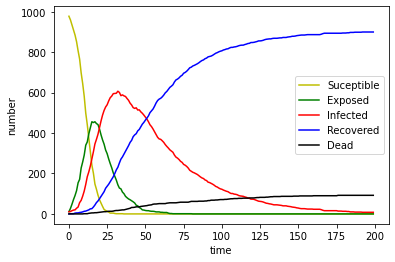

In [157]:
#Demonstrating that my simulation works by completing the given tasks

#task 1
test_sim = Simulation()
test_sim.run()
test_sim.chart()
#test_sim.plot_state(time=0, time=50, time=100)

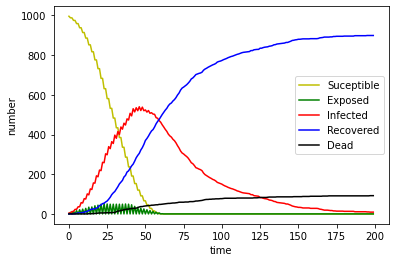

In [156]:
#task 2
#part a

#test_sim = Simulation(radius=2, infected_locations=[(0,0),(1,0),(0,1),(1,1)], prob_infects=1, prob_infectious=1)

#this raises a value error because the average number of contacts that can be attained depends on the radius
#the default value (20) cannot be achieved with a radius of 2
#the maximum number that can be achieved is 4+radius!*4 = 12
#this simulation will take a long time to run as all possible connections will need to be generated to find those that fit
#instead we use k=10

test_sim = Simulation(radius=2, n_contacts=10, infected_locations=[(0,0),(1,0),(0,1),(1,1)], prob_infects=1, prob_infectious=1)
test_sim.run()
test_sim.chart()
#test_sim.plot_state(2:20)

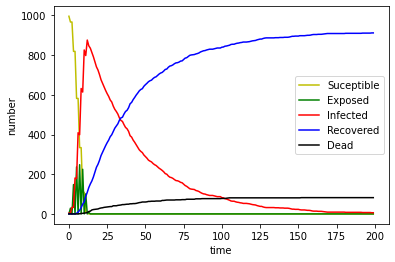

In [158]:
#task 2
#part b
test_sim = Simulation(radius=10, infected_locations=[(0,0),(1,0),(0,1),(1,1)], prob_infects=1, prob_infectious=1)
test_sim.run()
test_sim.chart()
#test_sim.plot_state(2:20)

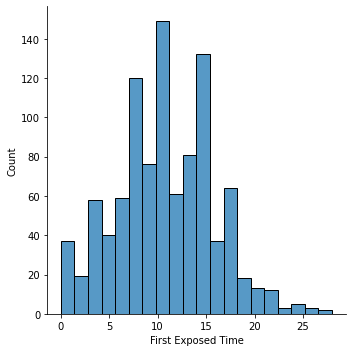

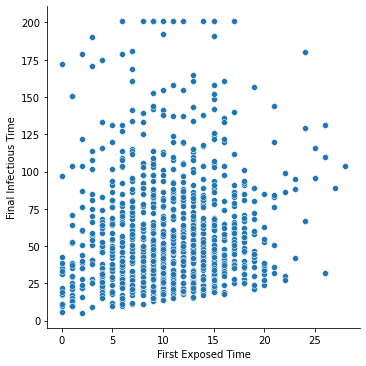

C:\Users\agnes\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


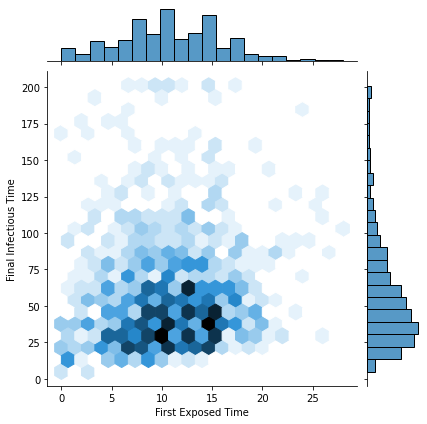

In [166]:
#task 3
test_sim = Simulation()
test_sim.run()
exposed_times = test_sim.disease_start_end()

sns.displot(exposed_times["First Exposed Time"], rug=False)
plt.show()
#the different peaks relate to where the random infections started for this simulation
#it would be interesting to plot this for several averaged simulations to see if it smoothed out
#I would predict that the distribution would appear smoother if infected_locations was used to create one initial centre
#rather than allowing the disease to spread from several random (and possibly disparate & disparetely connected) individuals


sns.relplot(x="First Exposed Time", y="Final Infectious Time", data=exposed_times)
plt.show()
#there seems to be a loose positive correlation
#this is intuitively correct as the 'Final Infectious Time' > 'First Exposed Time'
#the correlation is less visible strong because it is effected by the random element of when someone become infected
#and then when they become recovered/dead
#if the probabilities were set higher, we would expect to see a stronger correlation here

sns.jointplot("First Exposed Time", "Final Infectious Time", data=exposed_times, kind="hex")
plt.show()
#the distribution of 'Final Infectious Time' is far smoother than that of 'First Exposed Time'
#this may be because the random elements here have smoother the multimodal elements of exposure resulting from random start locations
#the hex plot echoes the results of the scatter plot above